# FDN Reverberator - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: 10557065, MATR: 953546 )

In [260]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import scipy as sp
import IPython.display as ipd
import copy
import random
import warnings

## Scheme of Feedback Delay Network

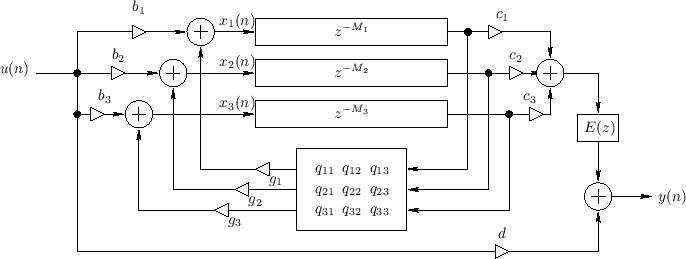

In [261]:
ipd.Image(filename = "images/FDNScheme.png")

## Function Definitions

In [262]:
def generateDelays(M_min, N, shuffle=False):
    primeN = []

    # generate some prime numbers...
    for num in range(2,501):
        prime = True
        for i in range(2,num):
            if (num%i==0):
                prime = False
        if prime:
            primeN.append(num)

    # compute M starting from (different) prime numbers
    M = []
    for i in primeN:
        m = np.floor(0.5+np.log(M_min)/np.log(i))
        if i**m>M_min:
            M.append(int(i**m))

    if(shuffle==False):
        M = np.sort(M)
    else:
        random.shuffle(M)

    return np.array(M[:N])

In [263]:
def generateMixMatrix(N, type='Had'):
    if(type=='Had'):
        # hadamard
        if((N & (N-1) == 0) and N != 0):
            mixMatrix = 1/np.sqrt(N)*sp.linalg.hadamard(N)
        else:
            mixMatrix = np.eye(N)
            warnings.warn("MIXING MATRIX DISABLED! Hadamard matrices can be computed only when N is a power of 2. Please, select N accordingly.")

    if(type=='Hous'):
        #householder
        u = np.ones(N)
        mixMatrix = np.identity(N)-2/N*u*u.T

    return np.array(mixMatrix)

### Filters

In [264]:
#plot a filter
def plotFilter(w, h, M_i):
        fig, ax1 = plt.subplots()
        if(M_i!='eq'):
                ax1.set_title('Filter applied to delay line with M={}'.format(M_i))
        else:
                ax1.set_title('Spectral Equalizer')
        ax1.plot(w, 20 * np.log10(abs(h)), 'b')
        ax1.set_ylabel('Amplitude [dB]', color='b')
        ax1.set_xlabel('Frequency [rad/sample]')
        plt.show()

In [265]:
#1st order LP filter
def filter1st(M_i, t60, fs, plot=False):
    filterCoeffs = []
    for M_i in M:
        R_M = []
        # R_M = 1-(6.91*M_i/t60*fs)
        for t60_f in t60:
            R_M.append(10**((-3*M_i)/(t60_f*fs))) 
            
        # pole
        p_i = (R_M[0]-R_M[-1])/(R_M[0]+R_M[-1])

        # gain
        g_i = 2*(R_M[0]*R_M[-1])/(R_M[0]+R_M[-1])   

        b = [g_i, 0]
        a = [1, -p_i]

        if(plot==True):
            w, h = sp.signal.freqz(b, a, fs=fs)
            print('Filter Coefficients: [a, b]=', [a, b])
            plotFilter(w, h, M_i)

        filterCoeffs.append([a, b])

    return np.array(filterCoeffs)


In [266]:
#orthogonalized 1st order LP filter (NOT WORKING)

def ortFilter1st(M_i, t60, fs, plot=False):
        filterCoeffs = []
        for M_i in M:
                # gain
                g_i = 10**((-3*M_i)/(t60[0]*fs))

                # pole and zero
                p_i = np.log(10)/4 * np.log10(g_i) * (1-(1/(t60[-1]/t60[0])**2))

                b = [g_i*(1-p_i), 0]
                a = [1, -p_i]

                if(plot==True):
                        w, h = sp.signal.freqz(b, a, fs=fs)
                        print('Filter Coefficients: [a, b]=', [a, b])
                        plotFilter(w, h, M_i)
                
                filterCoeffs.append([a, b])

        return np.array(filterCoeffs)


In [267]:
#multiband filter (preferred)

def multibandEqualizer(M, T, t60, freqs, fs, plot=False):
    filterTaps = []
    for M_i in M:

        G_i = []
        # evaluate correct gains (one per band)
        for t60_f in t60:
            G_i.append(10**((-3*M_i)/(t60_f*fs))) 

        taps = sp.signal.firwin2(numtaps=T, freq=freqs, gain=G_i, fs=fs)

        if(plot==True):
            w, h = sp.signal.freqz(taps, fs=fs)
            plotFilter(w, h, M_i)

        filterTaps.append(taps.tolist())

    return np.array(filterTaps)

In [268]:
#final spectral equalizer
def spectralEqualizer(t60, fs, plot=False):
    b_coeff = (1-(t60[-1]/t60[0]))/(1+(t60[-1]/t60[0]))

    b = [1, -b_coeff]
    a = [1-b_coeff]
    if(plot==True):
        w, h = sp.signal.freqz(b,a, fs=fs)
        plotFilter(w, h, 'eq')

    return [a, b]

## Reverb Computation:

### Signal

In [269]:
fs = 44100 # sampling rate
# signal = np.append(0.5*np.sin(2*np.pi*440*np.arange(0,0.1,1/fs)),np.zeros(15000)) #sp.signal.unit_impulse(22050)
# signal = sp.signal.unit_impulse(50000)*0.9
signal, _ = librosa.load('audio/voiced_a.wav', sr=fs, mono=True)

### Parameters

In [270]:
# parameters


N = 16 # number of parallel delay lines


# reverberation time should be function of frequency, from 0 to fs/2
T=7 # filter taps
t60 = [3, 3, 1, 0.5]

#t60 = [10, 0.1]
freqs = np.linspace(0, fs/2, len(t60))

print('Frequency bands {0} & relative reverberation times {1}'.format(freqs, t60)) 

# Delay lenghts
# TODO: create slider to select length (starting from min)
M_min = int(np.ceil(0.15*np.max(t60)*fs))

primeN = []

# generate some prime numbers...
for num in range(2,501):
    prime = True
    for i in range(2,num):
        if (num%i==0):
            prime = False
    if prime:
       primeN.append(num)

# compute M starting from (different) prime numbers
M = []
for i in primeN:
    m = np.floor(0.5+np.log(M_min)/np.log(i))
    if i**m>M_min:
        M.append(int(i**m))

M = np.sort(M)

M = M[:N]

print('Selected delay lengths:', M)
# TODO: select numbers according to min desired length


Frequency bands [    0  7350 14700 22050] & relative reverberation times [3, 3, 1, 0.5]
Selected delay lengths: [22201 22801 24389 24649 26569 27889 28561 29791 29929 32041 32761 36481
 37249 38809 39601 44521]


In [271]:
# diffusion before FDN:

sig = np.append(signal, np.zeros(2*np.max(M)))

# step 1: delay signal

# step 2: shuffle & polarity

# step 3: Had

In [272]:
output = np.zeros(sig.size)

bufferSize = np.max(M) + T +1

# filter design
filterType = 'multiband'
showPlot = False

if(filterType == 'multiband'):
    taps = np.zeros((N,T))
    taps = multibandEqualizer(M, T, t60, freqs, fs, plot=showPlot)
if(filterType == 'ort1stOrder'):
    filterCoeff = []
    filterCoeff = ortFilter1st(M, t60, fs, plot=showPlot)
if(filterType == '1stOrder'):
    filterCoeff = []
    filterCoeff = filter1st(M, t60, fs, plot=showPlot)


y = np.zeros(N).T
mix = np.zeros(N).T
filtered = np.zeros(N).T
prevFilt = np.zeros(N).T
x = np.zeros(N).T
out = np.zeros((N, np.max(M)+sig.size))

writeIndex = copy.deepcopy(M)
readIndex = np.zeros(N, dtype=int).T
channel = np.arange(N)

# print(writeIndex, readIndex)

filterIndex = copy.deepcopy(readIndex)
buffer = np.zeros((N, bufferSize))
j = 0

for sample in sig:

    # read the samples from the buffers
    y = buffer[channel, readIndex]
    
    # extract output
    out[:, j] = C*y
        
    # now mix up signals by applying feedback matrix (Q)
    mix = np.sum(y*mixMatrix, axis=1)

    # filter the signals (g)
    if(filterType == 'multiband'):
        # multiband FIR: y(n) = h_0*x(n) + h_1*x(n-1) + h_2*x(n-2) + ...
        filterIndex = readIndex # set current sample in the buffer
        # current sample multiplied by first tap h_0

        filtered = mix*taps[:, 0]

        for tapId in range(T-1):    
            filterIndex = filterIndex-1 # select previous sample index
            filterIndex[filterIndex<0] = bufferSize-1  
            filtered = filtered + buffer[channel, filterIndex]*taps[:,tapId] # cumulative sum of (samples (going backwards) * relative tap)

    if(filterType == 'ort1stOrder' or '1stOrder'):
        filtered = filtered*filterCoeff[:, 0, 1] + mix*filterCoeff[:, 1, 0]

    # new signal to be processed (input+feedback)
    x = B*sample + filtered*G

    # update buffer by writing new sample in correct position (delay)
    buffer[channel, writeIndex] = x

    # check if indices of the circular buffer are ok
    readIndex += 1
    writeIndex += 1   

    readIndex[readIndex>=bufferSize] = 0
    writeIndex[writeIndex>=bufferSize] = 0

    j = j+1

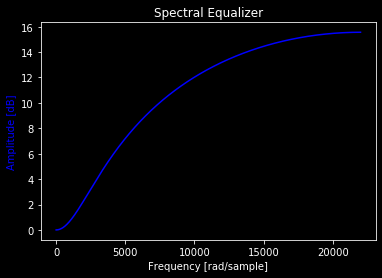

In [273]:
# tone equalization filter

a, b = spectralEqualizer(t60, fs, plot=True)

# output = np.sum(out, axis= 0) 
output = sp.signal.lfilter(b, a, np.sum(out, axis= 0)) 
output = (output / np.max(output))*np.max(signal) # normalize output to the original signal level


# final result
sig = np.append(signal, np.zeros(output.size-signal.size))
output = output + sig*d

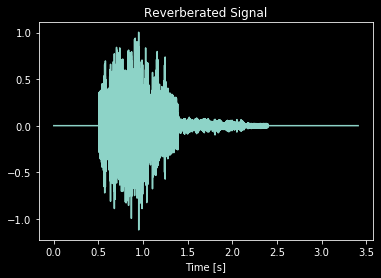

In [274]:

time = np.arange(0, len(output)) / fs
# plt.vlines(np.array(M), -1, 1, colors='r') # check if delays are correct
plt.plot(time, output)
plt.title('Reverberated Signal')
plt.xlabel('Time [s]')

ipd.display(ipd.Audio(output, rate=fs))